# Notebook 4 – Predictions and visualization

Purpose:
- Load the latest trained model.
- Fetch weather forecast for at least the next day and build future features.
- Generate price predictions for the forecast horizon.
- Optionally write predictions to a `electricity_prices_predictions` feature group.
- Produce plots (hourly price forecast, forecast vs actual) and save them under `plots/` for the dashboard.

Notes:
- Document where plots are stored and naming conventions.
- Mention any steps needed when the model version changes.
- Indicate how often this notebook is expected to run.


In [40]:
from pathlib import Path
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import json
import warnings
import holidays
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import hopsworks

# 1. Find project root (one level up from notebooks/)
root_dir = Path("..").resolve()

# 2. Add project root to PYTHONPATH so we can import the src package
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# 3. Load .env from project root
env_path = root_dir / ".env"
load_dotenv(env_path)

# 4. Load settings and utility functions (after adjusting PYTHONPATH)
from src.config import ElectricitySettings
from src import util

settings = ElectricitySettings()

# 5. Log in to Hopsworks and get feature store
project = hopsworks.login(engine="python")
fs = project.get_feature_store()


print("Successfully logged in to Hopsworks project:", settings.HOPSWORKS_PROJECT)


ElectricitySettings initialized
2025-12-22 21:00:38,474 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-12-22 21:00:38,475 INFO: Initializing external client
2025-12-22 21:00:38,476 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443


2025-12-22 21:00:39,318 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/127
Successfully logged in to Hopsworks project: ScalableProject


In [41]:
today = datetime.datetime.now() - datetime.timedelta(0)
yesterday = today - datetime.timedelta(days = 1)


In [42]:
secrets = hopsworks.get_secrets_api()
area = secrets.get_secret("ELECTRICITY_LOCATION_JSON").value
area = json.loads(area)
PRICE_AREA = area['price_area']
CITY = area['city']
LATITUDE = area['latitude']
LONGITUDE = area['longitude']

In [43]:
mr = project.get_model_registry()

# Load exact per-sensor model for this slug (no fallback)
model_name = f"electricity_prices_xgboost_model_lags_{PRICE_AREA.lower()}"
retrieved_model = mr.get_model(name=model_name)
if retrieved_model is None:
    raise RuntimeError(f"Model '{model_name}' not found in registry")

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Downloading: 0.000%|          | 0/5335463 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115919 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115919 elapsed<00:00 remaining<?

In [44]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='6.099053E-1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'int', 'in...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
# --- Fetch historical prices (last 4 days) to build lag features ---
electricity_prices_fg = fs.get_feature_group('electricity_prices', version=1)
lookback_start = (pd.Timestamp.utcnow() - pd.Timedelta(days=4)).normalize()

hist_prices = electricity_prices_fg.filter(
    (electricity_prices_fg.price_area == PRICE_AREA.lower()) &
    (electricity_prices_fg.date >= lookback_start)
).read()

hist_prices['date'] = pd.to_datetime(hist_prices['date'], utc=True)
hist_prices = hist_prices.sort_values('unix_time')[['price_area','date','hour','unix_time','price_sek']]

# --- Fetch weather forecast for kommande dagar ---
forecast_days = 2  
forecast_df = util.get_hourly_weather_forecast(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    city=PRICE_AREA.lower(),
    forecast_days=forecast_days,
)
forecast_df['date'] = pd.to_datetime(forecast_df['timestamp'], utc=True)
forecast_df['unix_time'] = forecast_df['date'].astype('int64') // 10**6
forecast_df['price_area'] = PRICE_AREA.lower()
forecast_df['price_area'] = forecast_df['price_area'].astype('string')
if 'city' in forecast_df.columns:
    forecast_df = forecast_df.drop(columns=['city'])
forecast_df = forecast_df.drop(columns=['timestamp'])

# Behåll bara imorgon
forecast_day = (pd.Timestamp.utcnow().normalize() + pd.Timedelta(days=1)).date()
forecast_df = forecast_df[forecast_df['date'].dt.date == forecast_day].copy()

# Kalender/helg/season/holiday
forecast_df['weekday'] = forecast_df['date'].dt.weekday.astype('int8')
forecast_df['is_weekend'] = forecast_df['weekday'].isin([5, 6]).astype('int8')
forecast_df['month'] = forecast_df['date'].dt.month.astype('int8')
season_map = {12: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3}
forecast_df['season'] = forecast_df['month'].map(season_map).astype('int8')
try:
    years = range(forecast_df['date'].dt.year.min(), forecast_df['date'].dt.year.max() + 1)
    se_holidays = holidays.Sweden(years=years)
    forecast_df['is_holiday'] = forecast_df['date'].dt.date.isin(se_holidays).astype('int8')
except Exception:
    forecast_df['is_holiday'] = 0

# --- Bygg lag features genom att kombinera historik + forecast-platshållare ---
forecast_prices = forecast_df[['price_area','date','hour','unix_time']].copy()
forecast_prices['price_sek'] = np.nan

lag_base = pd.concat([
    hist_prices[['price_area','date','hour','unix_time','price_sek']],
    forecast_prices
], ignore_index=True).sort_values('unix_time')

for lag in [24, 48, 72]:
    lag_base[f'price_lag_{lag}'] = lag_base.groupby('price_area')['price_sek'].shift(lag).astype('float32')

lag_base['price_roll3d'] = (
    lag_base.groupby('price_area')['price_sek']
            .rolling(72, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
            .astype('float32')
)

# Plocka ut lag-features för forecast-rader
lags_forecast = lag_base[lag_base['price_sek'].isna()][['unix_time','price_lag_24','price_lag_48','price_lag_72','price_roll3d']]
forecast_df = forecast_df.merge(lags_forecast, on='unix_time', how='left')

# --- Förbered feature-matris för inferens ---
# Matcha träningsnamn: price-features är prefixade av Hopsworks (electricity_prices_*)
forecast_df = forecast_df.copy()
forecast_df['electricity_prices_unix_time'] = forecast_df['unix_time']
forecast_df['electricity_prices_weekday'] = forecast_df['weekday']
forecast_df['electricity_prices_is_weekend'] = forecast_df['is_weekend']
forecast_df['electricity_prices_month'] = forecast_df['month']
forecast_df['electricity_prices_season'] = forecast_df['season']
forecast_df['electricity_prices_is_holiday'] = forecast_df['is_holiday']
forecast_df['electricity_prices_price_lag_24'] = forecast_df['price_lag_24']
forecast_df['electricity_prices_price_lag_48'] = forecast_df['price_lag_48']
forecast_df['electricity_prices_price_lag_72'] = forecast_df['price_lag_72']
forecast_df['electricity_prices_price_roll3d'] = forecast_df['price_roll3d']

feature_cols = [
    "price_area",
    "unix_time",
    "date",
    "hour",
    "temperature_2m", "apparent_temperature",
    "precipitation", "rain", "snowfall",
    "cloud_cover",
    "wind_speed_10m", "wind_speed_100m",
    "wind_direction_10m", "wind_direction_100m",
    "wind_gusts_10m",
    "surface_pressure",
    # prefixed price cols expected by model
    "electricity_prices_unix_time",
    "electricity_prices_weekday",
    "electricity_prices_is_weekend",
    "electricity_prices_month",
    "electricity_prices_season",
    "electricity_prices_is_holiday",
    "electricity_prices_price_lag_24",
    "electricity_prices_price_lag_48",
    "electricity_prices_price_lag_72",
    "electricity_prices_price_roll3d",
]
forecast_df = forecast_df[feature_cols]

cat_cols = [c for c in forecast_df.columns if 'price_area' in c]
X_pred = forecast_df.drop(columns=['date'] + cat_cols)

# --- Prediktera ---
predictions = retrieved_xgboost_model.predict(X_pred)
forecast_df['predicted_price_sek'] = predictions.astype('float32')

# Visa resultat för imorgon
print(forecast_df[['date','hour','predicted_price_sek']].sort_values(['date','hour']).head(24))


ValueError: Reading data with Hive is not supported when using hopsworks client version >= 4.0

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- INSTÄLLNINGAR ---
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Sökvägar
current_folder = os.getcwd()
project_root = os.path.dirname(current_folder)
if os.path.basename(current_folder) != "NotebooksElectricity":
    project_root = current_folder
img_path = os.path.join(project_root, "docs/PricesDashboard/assets/img")
os.makedirs(img_path, exist_ok=True)

# Hitta kolumnnamn för prediction i forecast_df
price_col = 'predicted_price_sek'
if 'prediction' in forecast_df.columns: price_col = 'prediction'

print(f"Genererar grafer till: {img_path}")


In [ ]:
# ==========================================
# GRAF 1: LADDA-GUIDEN
# ==========================================
mean_price = forecast_df[price_col].mean()
forecast_df['color'] = forecast_df[price_col].apply(lambda x: '#22c55e' if x < mean_price else '#ef4444')

plt.figure(figsize=(14, 7))
plt.bar(forecast_df['date'], forecast_df[price_col], color=forecast_df['color'], alpha=0.9, width=0.04)
plt.axhline(y=mean_price, color='gray', linestyle='--', alpha=0.5, label=f'Snittpris ({mean_price:.2f} kr)')

plt.title('Ladda Smart Imorgon: Grönt = Billigt', fontsize=18, pad=20)
plt.xlabel('Klockslag', fontsize=14)
plt.ylabel('Pris (SEK/kWh)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(img_path, "electricity_price_signal.png"), dpi=150)
plt.close()


In [ ]:
# ==========================================
# GRAF 2: FEATURE IMPORTANCE
# ==========================================
try:
    bst = retrieved_xgboost_model.get_booster()
    importance = bst.get_score(importance_type='weight')

    if not importance:
         importance = dict(zip(X_pred.columns, retrieved_xgboost_model.feature_importances_))

    imp_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Score'])
    imp_df['Feature'] = imp_df['Feature'].str.replace('electricity_prices_', '').str.replace('weather_', '')
    imp_df = imp_df.sort_values(by='Score', ascending=False).head(12)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Score', y='Feature', data=imp_df, palette='viridis')
    plt.title('Vad styr elpriset just nu?', fontsize=18, pad=20)
    plt.xlabel('Påverkan (Vikt)', fontsize=14)
    plt.ylabel('', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(img_path, "feature_importance.png"), dpi=150)
    plt.close()
except Exception as e:
    print(f"⚠️ Feature importance error: {e}")


🔄 Genererar trend-graf med historisk buffert...
   Hämtar data från 2025-12-11...
✅ Redo att rita graf från 2025-12-16 00:00:00+00:00 till 2025-12-23 22:00:00+00:00


NameError: name 'img_path' is not defined

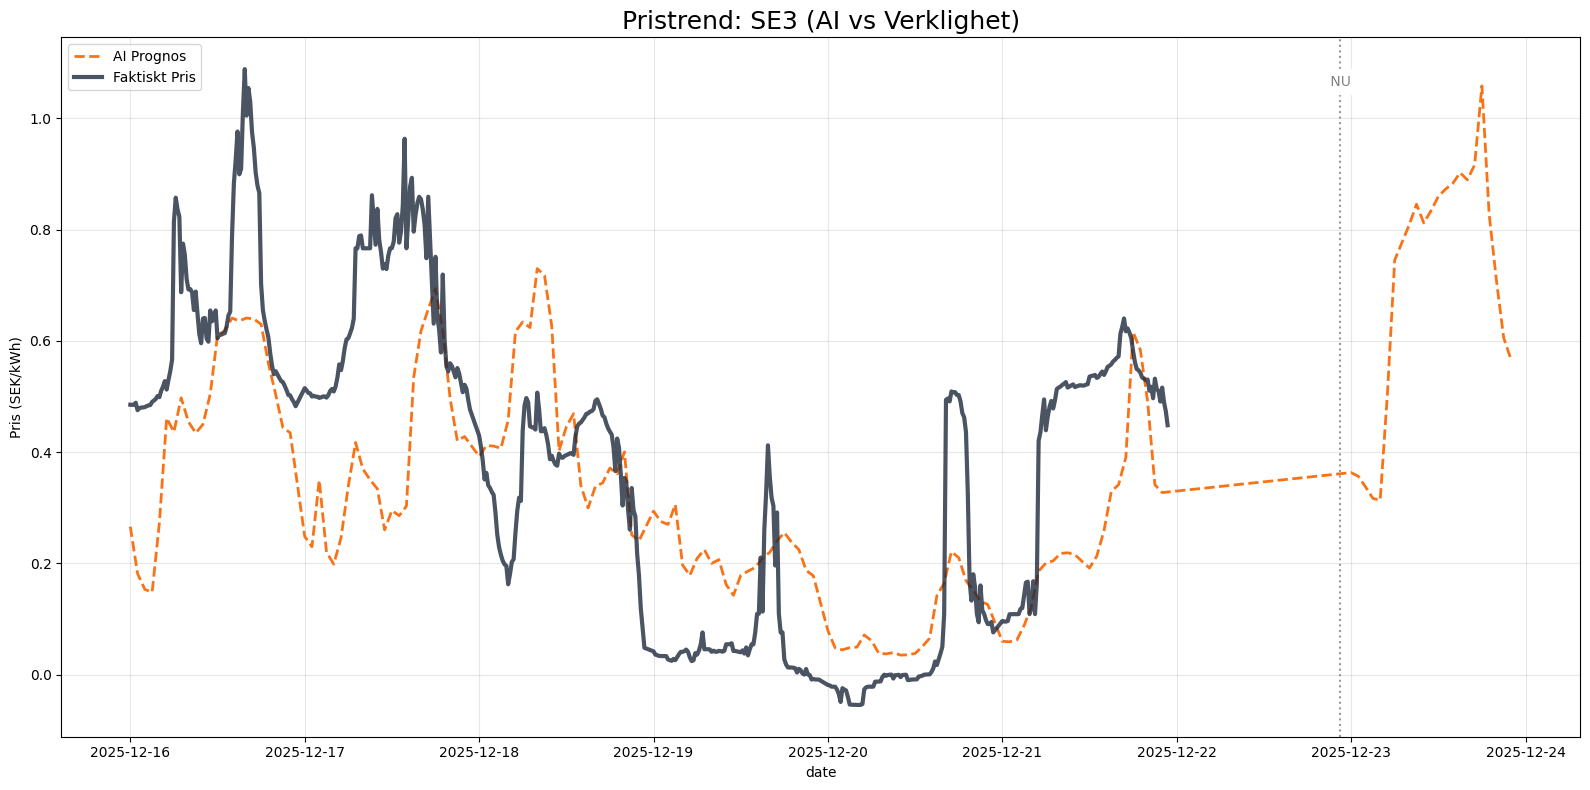

In [47]:
# ==========================================
# GRAF 3: TREND
# ==========================================

print("Genererar trend-graf för hela tidslinjen...")

# 1. HÄMTA DATA (Bara det som behövs)
# ----------------------------------------
# Vi hämtar priser från 3 dagar sen för att kunna räkna ut lags för "idag"
start_date = pd.Timestamp.utcnow() - pd.Timedelta(days=3)

# A. Historik
hist_prices = electricity_prices_fg.filter(
    (electricity_prices_fg.price_area == PRICE_AREA.lower()) &
    (electricity_prices_fg.date >= start_date)
).read(online=True)

hist_prices['date'] = pd.to_datetime(hist_prices['date'], utc=True)
hist_prices = hist_prices.sort_values('date').drop_duplicates('date')
hist_prices = hist_prices[['date', 'price_sek', 'price_area']]

# B. Historiskt Väder
weather_fg = fs.get_feature_group('weather_hourly', version=1)
hist_weather = weather_fg.filter(weather_fg.date >= start_date).read(online=True)
hist_weather['date'] = pd.to_datetime(hist_weather['date'], utc=True)

# C. Framtida Väder (Från API)
future_weather = forecast_df.copy()
# Rensa bort skräp så det inte krockar
bad_cols = [c for c in future_weather.columns if 'price' in c or 'lag' in c]
future_weather = future_weather.drop(columns=bad_cols, errors='ignore')


# 2. SLÅ IHOP ALLT (Hela tidslinjen)
# ----------------------------------------
# Slå ihop väder först
all_weather = pd.concat([hist_weather, future_weather], ignore_index=True)
all_weather = all_weather.sort_values('date').drop_duplicates('date')

# Koppla på priser (Historiska priser hamnar rätt, framtiden blir NaN)
full_df = all_weather.merge(hist_prices, on='date', how='left')


# 3. FIXA LAGS (Detta gör linjen kurvig!)
# ----------------------------------------
# Vi fyller framtida NaN-priser med priset från 24h sedan.
# Detta gör att "idag" baseras på "igår", och "imorgon" på "idag".
# Då får vi en naturlig kurva istället för en platt linje.
full_df = full_df.sort_values('date')
for _ in range(4): # Kör några gånger för att täcka hela framtiden
    full_df['price_sek'] = full_df['price_sek'].fillna(full_df['price_sek'].shift(24))

# Nu räknar vi lags på hela serien
full_df['price_lag_24'] = full_df['price_sek'].shift(24)
full_df['price_lag_48'] = full_df['price_sek'].shift(48)
full_df['price_lag_72'] = full_df['price_sek'].shift(72)
full_df['price_roll3d'] = full_df['price_sek'].rolling(72, min_periods=1).mean()


# 4. FIXA FEATURES & PREDIKTERA
# ----------------------------------------
full_df['hour'] = full_df['date'].dt.hour.astype('int8')
full_df['weekday'] = full_df['date'].dt.weekday.astype('int8')
full_df['is_weekend'] = full_df['weekday'].isin([5, 6]).astype('int8')
full_df['month'] = full_df['date'].dt.month.astype('int8')
full_df['season'] = full_df['month'].map(season_map).astype('int8')
full_df['is_holiday'] = 0
full_df['price_area'] = PRICE_AREA.lower()

# Mappa namn
full_df['unix_time'] = full_df['date'].astype('int64') // 10**6
full_df['electricity_prices_unix_time'] = full_df['unix_time']
full_df['electricity_prices_weekday'] = full_df['weekday']
full_df['electricity_prices_is_weekend'] = full_df['is_weekend']
full_df['electricity_prices_month'] = full_df['month']
full_df['electricity_prices_season'] = full_df['season']
full_df['electricity_prices_is_holiday'] = full_df['is_holiday']
full_df['electricity_prices_price_lag_24'] = full_df['price_lag_24']
full_df['electricity_prices_price_lag_48'] = full_df['price_lag_48']
full_df['electricity_prices_price_lag_72'] = full_df['price_lag_72']
full_df['electricity_prices_price_roll3d'] = full_df['price_roll3d']

# Välj ut perioden vi vill visa (Från midnatt IGÅR till framtiden)
plot_start = pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1)
plot_df = full_df[full_df['date'] >= plot_start].copy()

# Prediktera
X_all = plot_df[retrieved_xgboost_model.feature_names_in_].copy()
plot_df['predicted_price'] = retrieved_xgboost_model.predict(X_all)


# 5. RITA GRAFEN
# ----------------------------------------
plt.figure(figsize=(16, 8))

# A. Prediktion (Orange) - Täcker nu HELA perioden
sns.lineplot(
    x='date', y='predicted_price', data=plot_df,
    label='AI Prognos', color='#f97316', linewidth=2, linestyle='--'
)

# B. Faktiskt pris (Svart) - Bara där vi har riktig data
real_history = hist_prices[hist_prices['date'] >= plot_start].copy()
sns.lineplot(
    x='date', y='price_sek', data=real_history,
    label='Faktiskt Pris', color='#1e293b', linewidth=3, alpha=0.8
)

# Markera NU
now = pd.Timestamp.utcnow()
plt.axvline(x=now, color='gray', linestyle=':', alpha=0.8)
plt.text(now, plot_df['predicted_price'].max(), ' NU ', color='gray', ha='center', backgroundcolor='white')

plt.title(f'Pristrend: {PRICE_AREA}', fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_path = os.path.join(img_path, "price_trend.png")
plt.savefig(save_path, dpi=150)
print(f"✅ Graf sparad: {save_path}")
plt.show()